In [1]:
using FEM, Potential, Diffusity, PyPlot, Printf, JLD, Dierckx

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$

In [3]:
sigma_kref = 10.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq
F_xref = force_harmonic_well_k_mean.(xref, kref, xavg);

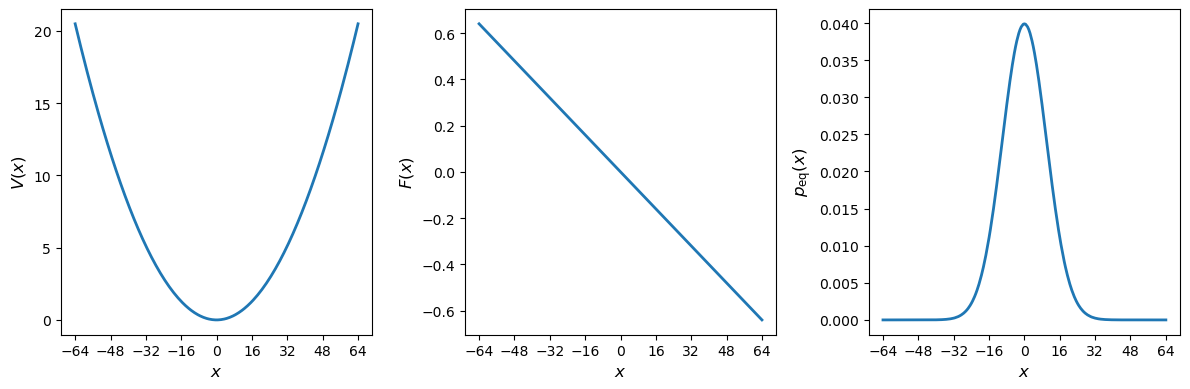

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, F_xref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$F(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[3]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/harmonic_potential_force_0.pdf")
plt.show()

### Part 3: Distance-dependent diffusion coefficient $D(x)$

In [7]:
xleft = -64
xright = 64
yleft = 250
yright = 750
c = 500
D_array = Diffusity.linear.(xleft, xright, yleft, yright, xref, c)
D_spl = Spline1D(xref[:,1], D_array[:,1]);

In [8]:
dDdx_xref = zeros(N)
for idx = 1:N
    dDdx_xref[idx] = derivative(D_spl, xref[idx])
end

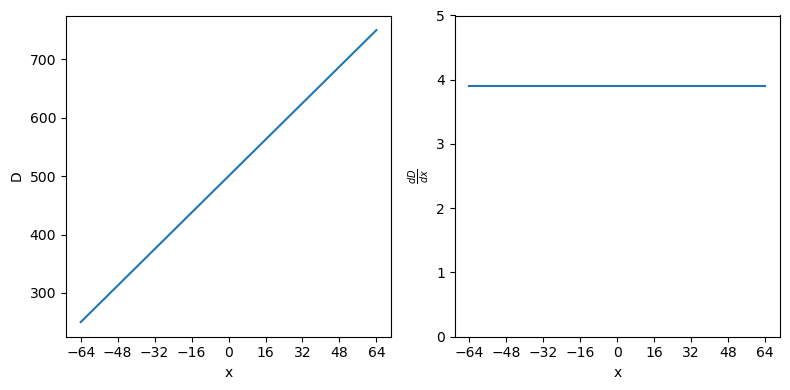

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, D_array)
ax.set_xlabel("x")
ax.set_ylabel("D")
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, dDdx_xref)
ax.set_xlabel("x")
ax.set_ylabel("\$\\frac{dD}{dx}\$")
ax.set_xticks(-64:16:64)
ax.set_ylim(0,5)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 4: Langevin dynamics Collect Separately

In [21]:
# physical parameters
save_freq = 2e-5 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s # 100
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 1 timesteps. There will be 5000000 data points.


In [22]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

first_term_record = zeros(tau, 1)
second_term_record = zeros(tau, 1)
third_term_record = zeros(tau, 1)

ypos = -32 # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    
    D =  Diffusity.linear.(xleft, xright, yleft, yright, ypos, c)
    dDdx = derivative(D_spl, ypos)
    F = force_harmonic_well_k_mean(ypos, kref, xavg)
        
    first_term = D*dt*F
    second_term = dDdx * dt
    third_term = (dt*2*D)^(1/2) * randn()
    
    first_term_record[tau_id] = first_term
    second_term_record[tau_id] = second_term
    third_term_record[tau_id] = third_term
        
    ypos = ypos + first_term + second_term + third_term
    t += dt   
    
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

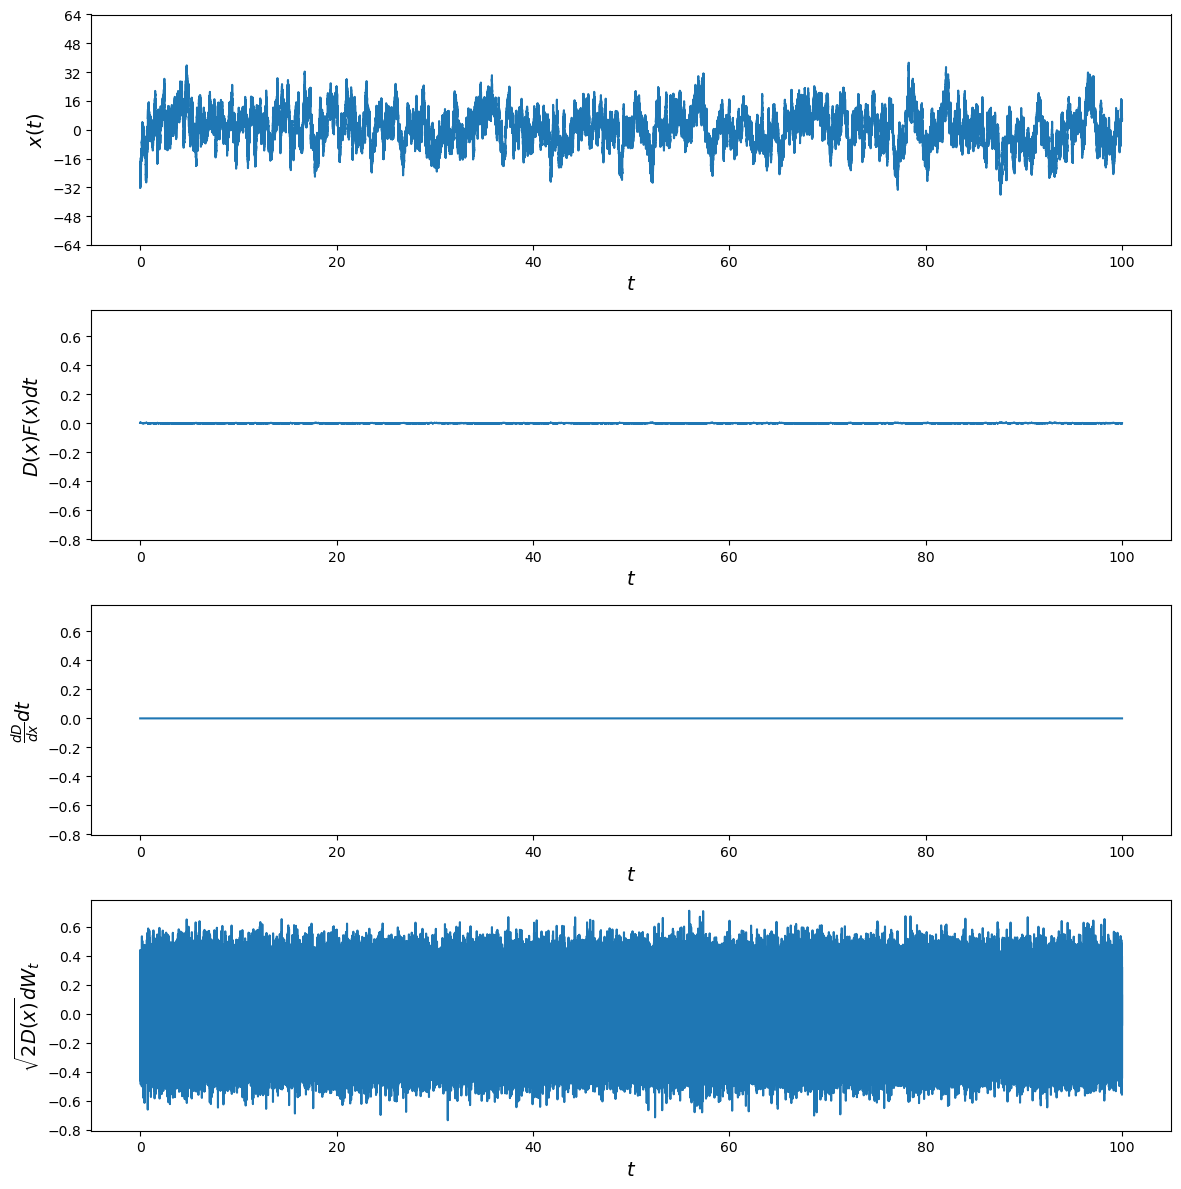

In [23]:
lbfz = 14
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(12,12))

ax = axes[1]
ax.plot(t_record, y_record)
ylims = ax.get_ylim()
ax.set_ylabel("\$x(t)\$", fontsize=lbfz)
ax.set_xlabel("\$t\$", fontsize=lbfz)
ax.set_yticks(-64:16:64)

ax = axes[2]
ax.plot(t_record[2:end], first_term_record)
ax.set_ylabel("\$D(x)F(x)dt\$", fontsize=lbfz)
ax.set_xlabel("\$t\$", fontsize=lbfz)

ax = axes[3]
ax.plot(t_record[2:end], second_term_record)
ax.set_ylabel("\$\\frac{dD}{dx}dt\$", fontsize=lbfz)
ax.set_xlabel("\$t\$", fontsize=lbfz)

ax = axes[4]
ax.plot(t_record[2:end], third_term_record)
ax.set_ylabel("\$\\sqrt{2D(x)}dW_t\$", fontsize=lbfz)
ax.set_xlabel("\$t\$", fontsize=lbfz)
ylims = ax.get_ylim()

axes[2].set_ylim(ylims)
axes[3].set_ylim(ylims)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/harmonic_traj_0.pdf")
plt.show()

### Part 5: Process output traj

In [27]:
save_freq_out = 1e-2 # unit: s, Save trajectory per 1e-2 s
tau_out = Int(round(total_times / save_freq_out, digits=0))  # Number of photons
n_interval_out = Int(round(save_freq_out / dt, digits=0));
time_info_out = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval_out tau_out
println(time_info_out)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [29]:
y_record_out = zeros(tau_out+1, 1)  # In HMM, observing variables Y(t)
t_record_out = zeros(tau_out+1, 1)

idx_old = 1
y_record_out[1] = y_record[idx_old]
t_record_out[1] = t_record[idx_old]

for tau_id = 2:tau_out+1
    idx_old += n_interval_out
    y_record_out[tau_id] = y_record[idx_old]
    t_record_out[tau_id] = t_record[idx_old]
end

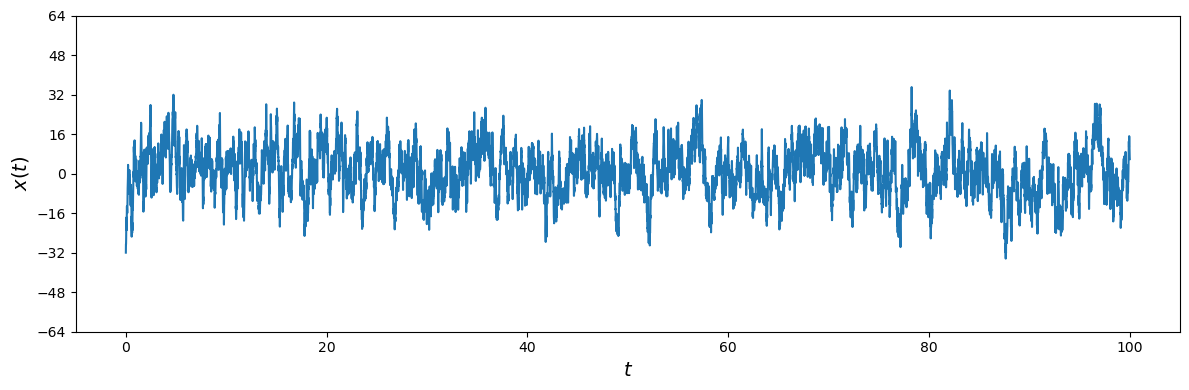

In [30]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record_out, y_record_out)
ylims = ax.get_ylim()
ax.set_ylabel("\$x(t)\$", fontsize=lbfz)
ax.set_xlabel("\$t\$", fontsize=lbfz)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/harmonic_traj_0.pdf")
plt.show()

### Part 4: Save trajectory or Read trajectory

In [32]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_varyD_0.jld"
save(f_out, "y_record", y_record_out, "t_record", t_record_out, "xref", xref, "rho_eq", rho_eq, "k_ref", 0)

In [36]:
# Read simulated trajectory from jld file
"""
f_in = "../trajectory/zeroforce_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");
"""

LoadError: [91mArgumentError: No file exists at given path: ../trajectory/zeroforce_tsim_10us_deltat_1ns.jld[39m